In [1]:
import pandas as pd

test_data = pd.read_csv("../clean_data/Cleaned_test_text_with_pii_\
2018_12_31_05_35_46_815414.csv")
train_data = pd.read_csv("../clean_data/Cleaned_train_text_with_pii_2018_12_29_07_26_56_266227.csv")

In [3]:
test_data.head()

,Text,Labels,PII,Cleaned_text,Target
0,Wife marriage cup 7416 Smith Forks before pict...,Address,7416 Smith Forks,wife marriage cup 7416 smith forks before pict...,1
1,However send which. Suite 244 Nice market acce...,Address,Suite 244,however send which suite 244 nice market accep...,1
2,0497 Kemp Lane Amount tough and fire until. Is...,Address,0497 Kemp Lane,0497 kemp lane amount tough and fire until iss...,1
3,Model north receive nature effort 58162 France...,Address,"58162 Frances Shoals Conniemouth, OH 71686",model north receive nature effort 58162 france...,1
4,Child already drive could. Begin such down cel...,Address,538 Gina Circles,child already drive could begin such down cell...,1


In [4]:
train_data.head()

,Text,Labels,PII,Cleaned_text,Target
0,Return never place become nearly movement. No ...,Address,"9479 Ward Creek Suite 474 Warnershire, NH 08434",return never place become nearly movement no s...,1
1,Quality recently seek Suite 937 goal relations...,Address,Suite 937,quality recently seek suite 937 goal relations...,1
2,Word expert reveal effect response forward. In...,Address,Apt. 925,word expert reveal effect response forward ind...,1
3,Son specific think. Conference its home expert...,Address,"15286 Ramirez Lakes Apt. 147 West Anthony, FL ...",son specific think conference its home expert ...,1
4,Control trouble Apt. 223 keep action rule. Sol...,Address,Apt. 223,control trouble apt 223 keep action rule soldi...,1


In [84]:
train_data.shape

(800000, 5)

In [65]:
%%time 
tokenized_sentences = [sentence.split(" ") for sentence in train_data['Cleaned_text']]
from gensim.models import FastText
model = FastText(tokenized_sentences, size=100, window=3, min_count=1, iter=10)

CPU times: user 14min 7s, sys: 2.12 s, total: 14min 10s
Wall time: 5min 35s


In [73]:
from tqdm import tqdm

def _find_part_pii(text, model, sep = " "):
    tokenized_text = text.split(sep)
    
    part_pii = model.wv.doesnt_match(tokenized_text)
    
    return part_pii   


extracted_pii = [_find_part_pii(sentence, model = model) for sentence in tqdm(train_data["Cleaned_text"]) ]

In [79]:
import numpy as np
from tqdm import tqdm
def _get_word2vec_matrix(pii_list, model):
    # set the matrix dimensions
    column_num = model.trainables.layer1_size
    row_num = len(pii_list)
    # initialized the matrix
    pii2vec_mat = np.zeros((row_num, column_num))
    # iterate through the pii_list and assign the vectors to matrix.
    for index, ith_pii in enumerate(tqdm(pii_list)):
        pii2vec_mat[index,:] = model.wv[ith_pii]
    
    return pii2vec_mat

In [80]:
# convert the extracted pii text into vectors.
pii_matrix = _get_word2vec_matrix(pii_list = extracted_pii, model = model)

100%|██████████| 800000/800000 [00:03<00:00, 244199.42it/s]


In [81]:
from yellowbrick.features.pca import PCADecomposition
import matplotlib.pyplot as plt
from visualizer import get_doc2vec_matrix, color_dict 

pii_labels = train_data["Labels"]
colors_map = pii_labels.map(color_dict)

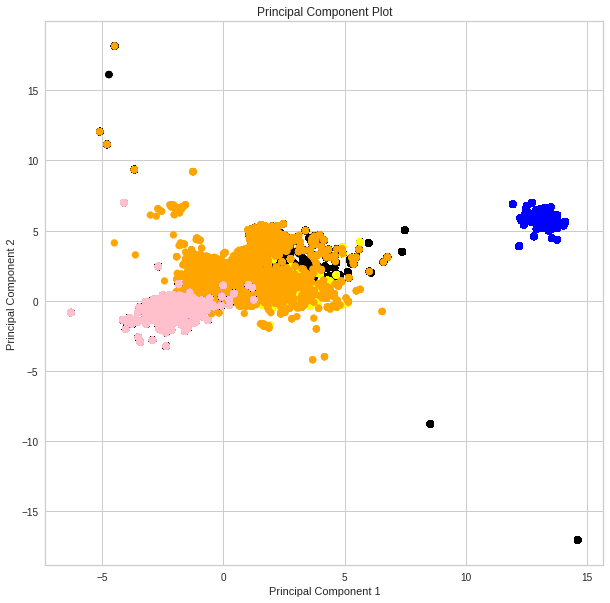

In [82]:
plt.figure(figsize=(10,10))
PCAvisualizer = PCADecomposition(scale=True, color = colors_map, proj_dim = 2)
PCAvisualizer.fit_transform(pii_matrix, pii_labels)
PCAvisualizer.poof()

In [83]:
color_dict

{'Phone_number': 'red',
 'SSN': 'blue',
 'Address': 'black',
 'Name': 'yellow',
 'Plates': 'orange',
 'CreditCardNumber': 'purple',
 'None': 'pink',
 'Email': 'tan'}

Train a logistic regression with CV

In [86]:
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [ ]:
%%time
%%notify -m "model finished training"

from sklearn.linear_model import LogisticRegression
from scipy.stats import expon
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(LogisticRegression(random_state=0 , max_iter=10000,n_jobs = 1))

param_grid = {
    'logisticregression__C':expon(scale = 2),
    'logisticregression__penalty':['l1','l2']
}

random_cv_lr_fasttext_100 = RandomizedSearchCV(estimator= pipe, param_distributions = param_grid, cv =10,\
                                        error_score = 0,n_iter = 10 , scoring = 'f1', \
                                        return_train_score=True,n_jobs = 2 )
                               


random_cv_lr_fasttext_100.fit(pii_matrix, train_data['Target'])

In [ ]:
%%time
%%notify -m "metric are ready"
from sklearn.metrics import classification_report

binary_pred = random_cv_lr_fasttext_100.predict(pii_matrix)
binary_true = train_data["Target"]
print(classification_report(y_true = binary_true, y_pred = binary_pred))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize= (8,8))
sns.heatmap(confusion_matrix(y_true = binary_true, y_pred = binary_pred), annot = True,fmt="d",cmap="YlGnBu")
plt.xlabel("Predicted values")
plt.ylabel("True values")

In [ ]:
def _match_re_and_extract_cv_scores(model,all_cv_keys, regex):
    match_keys = re.findall(regex," ".join(all_cv_keys))
    
    cv_scores = dict()
    
    for key in match_keys:
        cv_scores[key] = model.cv_results_[key]
    return cv_scores 


def extract_sk_cv(model, test = True):
    """
    A helper function to extract the training/testing cross validation result
    """
    all_cv_keys = model.cv_results_.keys()
    
    if test:
        sk_cv_result =  _match_re_and_extract_cv_scores(model = model,all_cv_keys = all_cv_keys\
                                                             ,regex = r"split[0-9]+_test_score")
        return pd.DataFrame(sk_cv_result)

    elif not test:
        
        sk_cv_result = _match_re_and_extract_cv_scores(model = model,all_cv_keys = all_cv_keys\
                                                             ,regex = r"split[0-9]+_train_score")
        return pd.DataFrame(sk_cv_result)
        

In [ ]:
import seaborn as sns
plt.figure(figsize = (8,8))
sns.boxenplot(data=extract_sk_cv(random_cv_lr_fasttext_100), orient="h");